In [1]:
import sqlite3         
import pandas as pd    
import numpy as np    
import matplotlib.pyplot as plt  
import seaborn as sns  
import plotly.express as px  
import scipy.stats as stats  

# Write an SQL query to extract and save a .csv file containing relevant category data

In [2]:
# Connecting to a SQLite Database
conn = sqlite3.connect(r'D:\L Leng\master of analytics\156761 Customer Insights\A2\A2\Assignment2.db')

In [3]:
# Query all table names in the database
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = conn.execute(tables_query).fetchall()

for table in tables:
    print(table[0])

dh_causal_lookup
dh_product_lookup
dh_transactions


In [4]:
# 1. View the field information of dh_causal_lookup
table_name = 'dh_causal_lookup'  
columns_query = f"PRAGMA table_info({table_name});"
columns = conn.execute(columns_query).fetchall()

for column in columns:
    print(f"Column ID: {column[0]}, Name: {column[1]}, Type: {column[2]}")
    
# 2. View the field information of dh_product_lookup
table_name = 'dh_product_lookup'  
columns_query = f"PRAGMA table_info({table_name});"
columns = conn.execute(columns_query).fetchall()

for column in columns:
    print(f"Column ID: {column[0]}, Name: {column[1]}, Type: {column[2]}")
    
# 3. View the field information of dh_transactions
table_name = 'dh_transactions'  
columns_query = f"PRAGMA table_info({table_name});"
columns = conn.execute(columns_query).fetchall()

for column in columns:
    print(f"Column ID: {column[0]}, Name: {column[1]}, Type: {column[2]}")

Column ID: 0, Name: upc, Type: REAL
Column ID: 1, Name: store, Type: INTEGER
Column ID: 2, Name: week, Type: INTEGER
Column ID: 3, Name: feature_desc, Type: TEXT
Column ID: 4, Name: display_desc, Type: TEXT
Column ID: 5, Name: geography, Type: INTEGER
Column ID: 0, Name: upc, Type: INTEGER
Column ID: 1, Name: product_description, Type: TEXT
Column ID: 2, Name: commodity, Type: TEXT
Column ID: 3, Name: brand, Type: TEXT
Column ID: 4, Name: product_size, Type: TEXT
Column ID: 0, Name: upc, Type: INTEGER
Column ID: 1, Name: dollar_sales, Type: REAL
Column ID: 2, Name: units, Type: INTEGER
Column ID: 3, Name: time_of_transaction, Type: INTEGER
Column ID: 4, Name: geography, Type: INTEGER
Column ID: 5, Name: week, Type: INTEGER
Column ID: 6, Name: household, Type: INTEGER
Column ID: 7, Name: store, Type: INTEGER
Column ID: 8, Name: basket, Type: INTEGER
Column ID: 9, Name: day, Type: INTEGER
Column ID: 10, Name: coupon, Type: INTEGER


In [7]:
# Perform inner joins to extract related data
query = """
SELECT 
    t.upc,
    t.dollar_sales,
    t.units,
    t.time_of_transaction,
    t.week,
    t.household,
    t.basket,
    p.brand,
    p.product_description,
    p.commodity
FROM 
    dh_transactions t
JOIN 
    dh_product_lookup p 
ON 
    t.upc = p.upc;
"""

In [8]:
# Execute the query and save the results as a pandas DataFrame
df = pd.read_sql_query(query, conn)

In [9]:
# Export query results to a CSV file
df.to_csv('relevant_category_data.csv', index=False)

# Use Python and Jupyter notebooks to clean the data

In [3]:
# Reload data from a CSV file
df = pd.read_csv('relevant_category_data.csv')

print(df.head())

          upc  dollar_sales  units  time_of_transaction  week  household  \
0  7680850106          0.80      1                 1100     1     125434   
1  3620000470          3.59      1                 1100     1     125434   
2  1800028064          2.25      1                 1137     1     108320   
3  9999985067          0.85      1                 1148     1     162016   
4  9999985131          2.19      1                 1323     1      89437   

   basket                  brand             product_description  \
0       1                Barilla              BARILLA ANGEL HAIR   
1       1               Bertolli        BERTOLLI TOM&BASIL SAUCE   
2       2            Hungry Jack       H J PANCK BTRMLK COMP MIX   
3       3          Private Label        PRIVATE LABEL VERMICELLI   
4       4  Private Label Premium  PRIVATE LABEL IMPORTED LASAGNA   

       commodity  
0          pasta  
1    pasta sauce  
2  pancake mixes  
3          pasta  
4          pasta  


## 1. Check for missing and duplicate values

In [4]:
# Check if there are any missing values
missing_values = df.isnull().sum()
print("Missing value statistics:\n", missing_values)

# Remove Duplicate Rows
df = df.drop_duplicates()

Missing value statistics:
 upc                    0
dollar_sales           0
units                  0
time_of_transaction    0
week                   0
household              0
basket                 0
brand                  0
product_description    0
commodity              0
dtype: int64


## 2. Time column processing

In [5]:
# Make sure 'time_of_transaction' is in date format
df['time_of_transaction'] = pd.to_datetime(df['time_of_transaction'], errors='coerce')

# Check if there are any invalid dates or dates that failed conversion
invalid_dates = df[df['time_of_transaction'].isnull()]
print("Invalid date entry:\n", invalid_dates)

Invalid date entry:
 Empty DataFrame
Columns: [upc, dollar_sales, units, time_of_transaction, week, household, basket, brand, product_description, commodity]
Index: []


In [6]:
# Check data volume by week
weekly_counts = df['week'].value_counts().sort_index()
print("Trading volume by week:\n", weekly_counts)

Trading volume by week:
 1      43148
2      45735
3      54344
4      53512
5      43824
       ...  
100    47815
101    50571
102    47365
103    49884
104    53626
Name: week, Length: 104, dtype: int64


In [7]:
# Delete data with incomplete time periods
df_cleaned = df.dropna(subset=['time_of_transaction', 'week'])

In [8]:
# Check the cleaned data
print(df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5197681 entries, 0 to 5197680
Data columns (total 10 columns):
 #   Column               Dtype         
---  ------               -----         
 0   upc                  int64         
 1   dollar_sales         float64       
 2   units                int64         
 3   time_of_transaction  datetime64[ns]
 4   week                 int64         
 5   household            int64         
 6   basket               int64         
 7   brand                object        
 8   product_description  object        
 9   commodity            object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(3)
memory usage: 436.2+ MB
None


## 3. Filter outliers

In [9]:
# Set pandas not to use scientific notation
pd.set_option('display.float_format', '{:.2f}'.format)

# Re-examine the descriptive statistics
print(df.describe())

                upc  dollar_sales      units       week  household     basket
count    5197681.00    5197681.00 5197681.00 5197681.00 5197681.00 5197681.00
mean  6203548088.76          1.76       1.20      53.22  223137.62 1662961.43
std   3152023380.33          1.13       0.57      30.05  141216.42  959318.89
min    111112360.00        -11.76       1.00       1.00       1.00       1.00
25%   3620000300.00          0.99       1.00      27.00   99053.00  829906.00
50%   5100012910.00          1.50       1.00      55.00  209694.00 1666884.00
75%   9999981583.00          2.19       1.00      79.00  339568.00 2496495.00
max   9999985766.00        153.14     156.00     104.00  510027.00 3316349.00


In [10]:
# Delete records with negative sales
df_cleaned = df[df['dollar_sales'] >= 0]

# Check the cleaned data
print(df_cleaned.describe())

# Reassign the cleaned data to df
df = df_cleaned

                upc  dollar_sales      units       week  household     basket
count    5193177.00    5193177.00 5193177.00 5193177.00 5193177.00 5193177.00
mean  6204517447.02          1.76       1.20      53.23  223121.95 1663045.33
std   3152341097.98          1.13       0.57      30.05  141227.64  959354.44
min    111112360.00          0.00       1.00       1.00       1.00       1.00
25%   3620000300.00          0.99       1.00      27.00   99006.00  830008.00
50%   5100012910.00          1.50       1.00      55.00  209669.00 1666846.00
75%   9999981583.00          2.19       1.00      79.00  339573.00 2496690.00
max   9999985766.00        153.14     156.00     104.00  510027.00 3316349.00


# Creating Customer Dashboard and Visualization

## 1. Customer Dashboard

### 1. 1 customer dashboard for the focal brand(MUELLER)

In [11]:
# Generates the 'Quarter' column for every 13 weeks in a quarter
df['Quarter'] = (df['week'] - 1) // 13 + 1

print(df[['week', 'Quarter']].head())

   week  Quarter
0     1        1
1     1        1
2     1        1
3     1        1
4     1        1


In [12]:
# Filter out the data of focal brand -- 'Mueller'
focal_brand = 'Mueller'
df_focal = df[df['brand'] == focal_brand]

# Summary of focal brand key indicators by quarter
focal_metrics = df_focal.groupby('Quarter').agg(
    Total_Revenue=('dollar_sales', 'sum'),  
    Total_Units=('units', 'sum'),  
    Total_SKUs=('upc', 'nunique'),  
    Total_Baskets=('basket', 'nunique'),  
    Total_Households=('household', 'nunique')  
)

print(focal_metrics)

         Total_Revenue  Total_Units  Total_SKUs  Total_Baskets  \
Quarter                                                          
1             37925.61        47181          25          28223   
2             33974.97        31650          24          25205   
3             32778.68        39601          27          26702   
4             32567.47        25324          25          20941   
5             33114.07        25351          24          20540   
6             37116.89        27743          23          22769   
7             32499.61        26719          21          21793   
8             30873.20        25830          21          21074   

         Total_Households  
Quarter                    
1                   22140  
2                   19270  
3                   21078  
4                   16863  
5                   16589  
6                   17903  
7                   17202  
8                   16719  


### 1.2 customer dashboard for the Competitive Performance

In [13]:
# Aggregate sales and purchase data for all brands in different quarters, by brand and quarter
competitive_metrics = df.groupby(['Quarter', 'brand']).agg(
    Total_Revenue=('dollar_sales', 'sum'),  
    Total_Units=('units', 'sum'),  
    Total_Baskets=('basket', 'nunique'),  
    Total_Households=('household', 'nunique')  
).reset_index()

# Exclude the 'Mueller' brand and sort the brands by total sales
top_10_brands = competitive_metrics[competitive_metrics['brand'] != 'Mueller'].groupby('brand').agg(
    Total_Revenue=('Total_Revenue', 'sum')
).reset_index().sort_values(by='Total_Revenue', ascending=False).head(10)

# Get data on the top 10 brands
top_10_metrics = competitive_metrics[competitive_metrics['brand'].isin(top_10_brands['brand'])]
print(top_10_metrics)

     Quarter                  brand  Total_Revenue  Total_Units  \
6          1            Aunt Jemima       72361.99        28130   
7          1                Barilla       69294.24        48762   
9          1               Bertolli       27095.80         9554   
20         1               Classico       60181.43        24752   
24         1              Creamette       37091.72        35557   
..       ...                    ...            ...          ...   
756        8                 Hunt's       28833.15        32423   
786        8                  Prego       92435.64        45327   
787        8          Private Label      216700.10       255201   
788        8  Private Label Premium       50300.09        34400   
791        8                   Ragu      176330.57       100928   

     Total_Baskets  Total_Households  
6            25377             20666  
7            33267             25189  
9             7905              6308  
20           17613             13526  


### 1.3 customer dashboard for the Category Demand Trends

In [14]:
# Aggregate sales and purchase data for the entire category in different quarters
category_metrics = df.groupby('Quarter').agg(
    Total_Category_Revenue=('dollar_sales', 'sum'),  
    Total_Category_Units=('units', 'sum'),  
    Total_Category_Baskets=('basket', 'nunique'),  
    Total_Category_Households=('household', 'nunique')  
)

print(category_metrics)

         Total_Category_Revenue  Total_Category_Units  Total_Category_Baskets  \
Quarter                                                                         
1                    1141361.63                765849                  404337   
2                    1159413.84                735915                  418127   
3                    1140770.75                776400                  414608   
4                    1007255.96                683649                  368721   
5                    1135519.88                776148                  413475   
6                    1207767.57                823988                  446374   
7                    1220550.05                880329                  446205   
8                    1118279.40                772252                  403685   

         Total_Category_Households  
Quarter                             
1                           190704  
2                           197483  
3                           195335  
4   

## 2. Visualization

### 2.1 Quarterly sales trends for Focal Brand

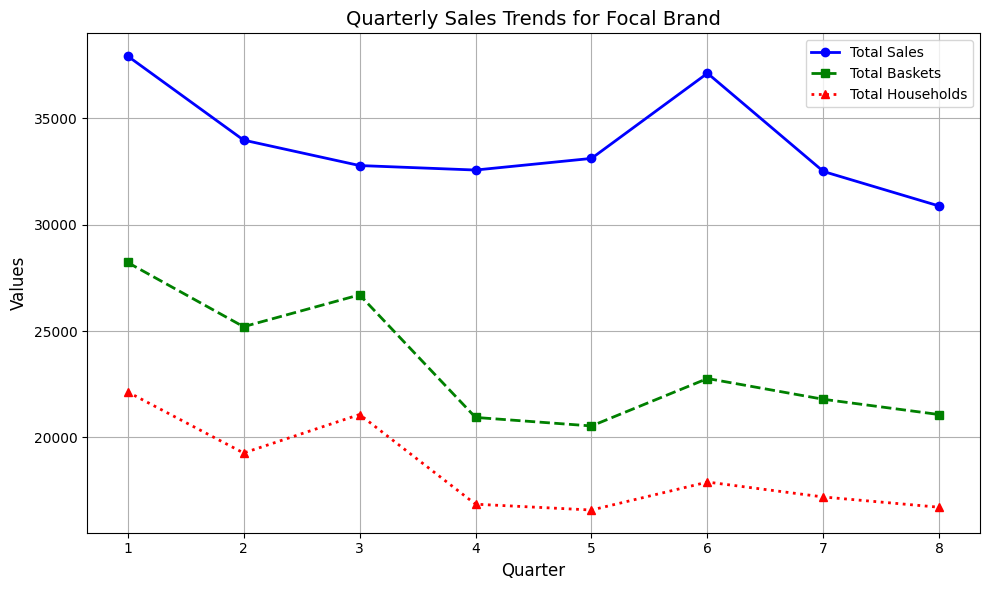

In [15]:
# Summarize the quarterly sales data of focal brand and add the summaries of basket and household
focal_sales_by_quarter = df_focal.groupby('Quarter').agg(
    Total_Sales=('dollar_sales', 'sum'),
    Total_Baskets=('basket', 'nunique'),  
    Total_Households=('household', 'nunique')  
)

plt.figure(figsize=(10, 6))

# Draw a line chart of sales
plt.plot(focal_sales_by_quarter.index, focal_sales_by_quarter['Total_Sales'], 
         marker='o', linestyle='-', color='blue', linewidth=2, label='Total Sales')

# Plot a trend graph for baskets and households
plt.plot(focal_sales_by_quarter.index, focal_sales_by_quarter['Total_Baskets'], 
         marker='s', linestyle='--', color='green', linewidth=2, label='Total Baskets')
plt.plot(focal_sales_by_quarter.index, focal_sales_by_quarter['Total_Households'], 
         marker='^', linestyle=':', color='red', linewidth=2, label='Total Households')

plt.title('Quarterly Sales Trends for Focal Brand', fontsize=14)
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(focal_sales_by_quarter.index)  
plt.tight_layout()
plt.show()

### 2.2 Comparison of performance of competing brands

#### 2.2.1 Comparison of sales of the top 10 brands

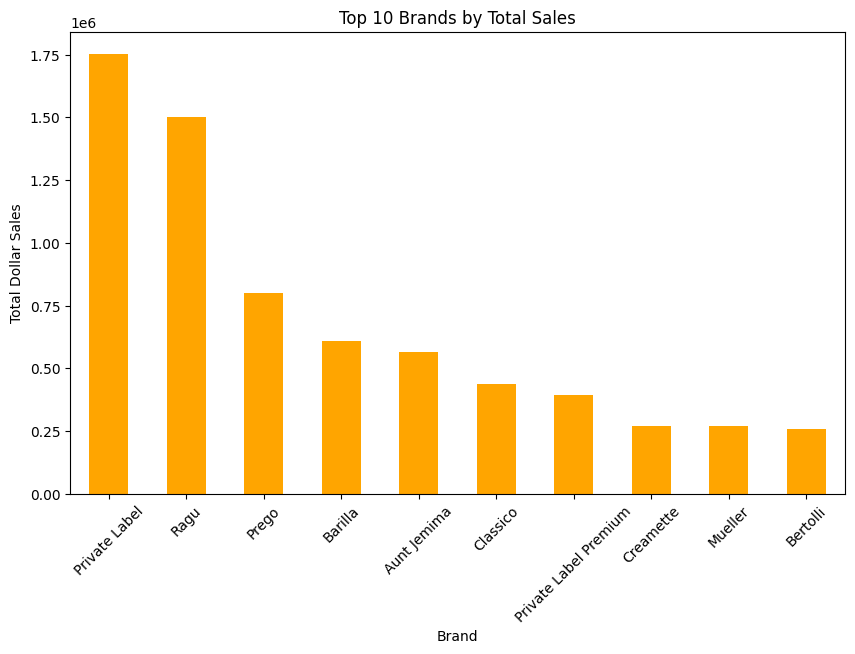

In [16]:
# Calculate total sales for all brands
brand_sales = df.groupby('brand')['dollar_sales'].sum().sort_values(ascending=False)

# Select the top 10 brands for analysis
top_brands = brand_sales.head(10)

# Draw a bar chart of sales of the top 10 brands
plt.figure(figsize=(10,6))
top_brands.plot(kind='bar', color='orange')
plt.title('Top 10 Brands by Total Sales')
plt.xlabel('Brand')
plt.ylabel('Total Dollar Sales')
plt.xticks(rotation=45)
plt.show()

#### 2.2.2 Compare focal brand to competing brands

In [17]:
# Check the sales summary of focal brand Mueller
focal_sales = df_focal.groupby('Quarter')['dollar_sales'].sum()
print(focal_sales)

Quarter
1   37925.61
2   33974.97
3   32778.68
4   32567.47
5   33114.07
6   37116.89
7   32499.61
8   30873.20
Name: dollar_sales, dtype: float64


C:\Users\23968\AppData\Local\Temp\ipykernel_7344\478139940.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


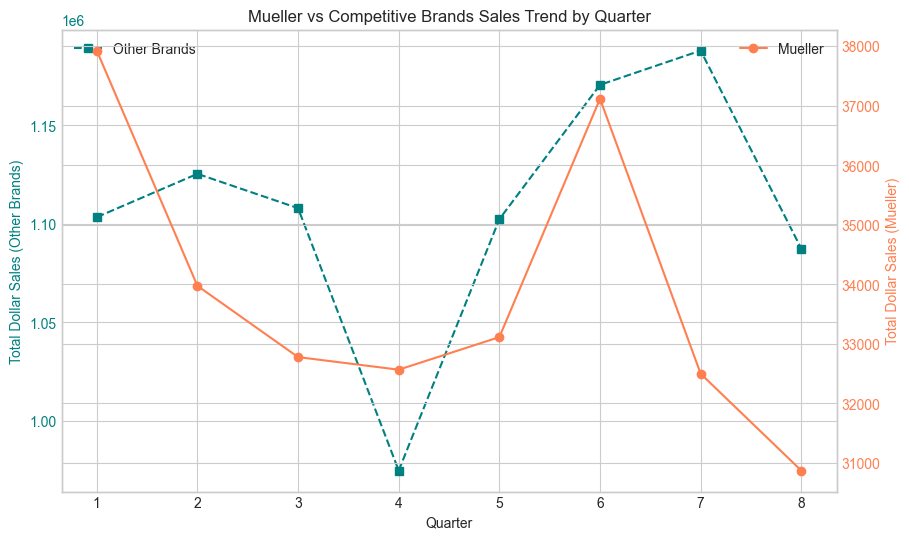

In [18]:
# Calculate the quarterly sales of competing brands
competitive_sales = df[df['brand'] != focal_brand].groupby('Quarter')['dollar_sales'].sum()

plt.style.use('seaborn-whitegrid')
fig, ax1 = plt.subplots(figsize=(10,6))

# Plotting the quarterly sales trends of competing brands (left axis)
ax1.plot(competitive_sales.index, competitive_sales.values, marker='s', linestyle='--', color='teal', label='Other Brands')
ax1.set_xlabel('Quarter')
ax1.set_ylabel('Total Dollar Sales (Other Brands)', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')

# Plotting Mueller's quarterly sales trend (right axis)
ax2 = ax1.twinx()
ax2.plot(focal_sales.index, focal_sales.values, marker='o', linestyle='-', color='coral', label='Mueller')
ax2.set_ylabel('Total Dollar Sales (Mueller)', color='coral')
ax2.tick_params(axis='y', labelcolor='coral')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Mueller vs Competitive Brands Sales Trend by Quarter')
plt.show()

#### 2.2.3 Charting Category Demand Trends

In [19]:
# Summarize sales and purchases for the entire category by quarter and keep 'Quarter'
category_metrics = df.groupby('Quarter').agg(
    Total_Category_Revenue=('dollar_sales', 'sum'),  
    Total_Category_Units=('units', 'sum')  
).reset_index()  

print(category_metrics.columns)

Index(['Quarter', 'Total_Category_Revenue', 'Total_Category_Units'], dtype='object')


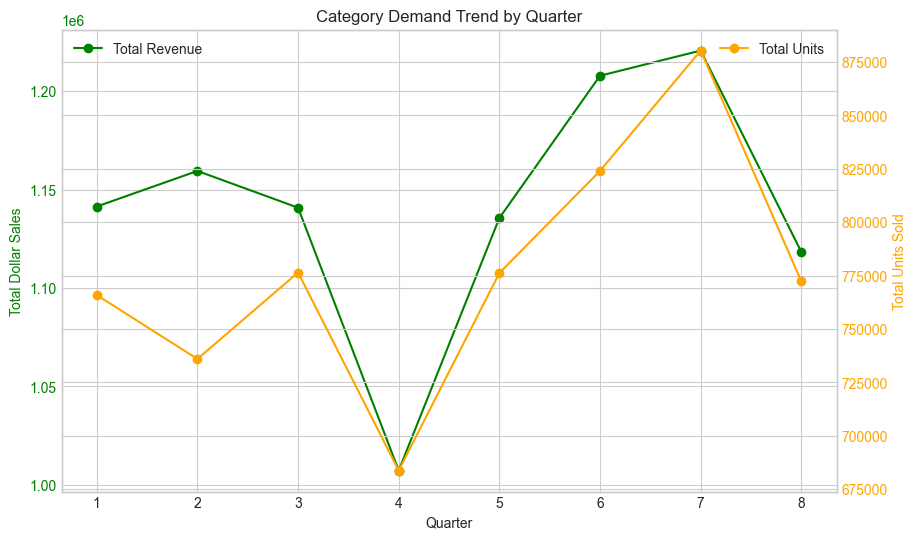

In [20]:
# Redraw the chart
fig, ax1 = plt.subplots(figsize=(10,6))

# Plotting total sales trends by category
ax1.plot(category_metrics['Quarter'], category_metrics['Total_Category_Revenue'], marker='o', color='green', label='Total Revenue')
ax1.set_xlabel('Quarter')
ax1.set_ylabel('Total Dollar Sales', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Using the shared x-axis of ax1, plot the trend of total purchases by category
ax2 = ax1.twinx()
ax2.plot(category_metrics['Quarter'], category_metrics['Total_Category_Units'], marker='o', color='orange', label='Total Units')
ax2.set_ylabel('Total Units Sold', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Category Demand Trend by Quarter')
plt.grid(True)
plt.show()

# Calculate the relevant data required for the Dirichlet spreadsheet

## 1. Calculate category data

In [21]:
# Filter out data for the Pasta category
df_pasta = df[df['commodity'] == 'pasta']

# Calculate the total sales, total number of orders, and total number of households in the Pasta category
total_revenue_pasta = df_pasta['dollar_sales'].sum()
total_baskets_pasta = df_pasta['basket'].nunique()
total_households_pasta = df_pasta['household'].nunique()

# Assume total_market_revenue is the total market revenue
total_market_revenue = df['dollar_sales'].sum()

# Calculate Market Share (B)
market_share_B = total_revenue_pasta / total_market_revenue
print(f"Market Share (B): {market_share_B:.2%}")

# Calculate Purchase Frequency (W)
purchase_frequency_W = total_baskets_pasta / total_households_pasta
print(f"Purchase Frequency (W): {purchase_frequency_W:.2f}")

Market Share (B): 31.24%
Purchase Frequency (W): 4.76


## 2. Calculate data of focal brand

In [22]:
focal_brand = 'Mueller'
df_focal = df[df['brand'] == focal_brand]

total_revenue_focal = df_focal['dollar_sales'].sum()
total_baskets_focal = df_focal['basket'].nunique()
total_households_focal = df_focal['household'].nunique()

total_category_revenue = df[df['commodity'] == 'pasta']['dollar_sales'].sum()

# Calculate the Market Share of the focal brand (B)
market_share_B_focal = total_revenue_focal / total_category_revenue
print(f"Focal Brand Market Share (B): {market_share_B_focal:.2%}")

# Calculate the purchase frequency (W) of the focal brand
purchase_frequency_W_focal = total_baskets_focal / total_households_focal
print(f"Focal Brand Purchase Frequency (W): {purchase_frequency_W_focal:.2f}")

Focal Brand Market Share (B): 9.50%
Focal Brand Purchase Frequency (W): 2.06


## 3. Calculate data of competing brands

In [23]:
last_complete_quarter = competitive_metrics['Quarter'].max()
last_quarter_data = competitive_metrics[(competitive_metrics['brand'] != 'Mueller') & 
                                        (competitive_metrics['Quarter'] == last_complete_quarter)]

# Calculate the market share (B) and purchase frequency (W) of each brand
last_quarter_data['Market_Share_B'] = last_quarter_data['Total_Revenue'] / last_quarter_data['Total_Revenue'].sum()
last_quarter_data['Purchase_Frequency_W'] = last_quarter_data['Total_Baskets'] / last_quarter_data['Total_Households']

# Sort by sales and extract the top 10 brands
top_10_brands_last_quarter = last_quarter_data.sort_values(by='Total_Revenue', ascending=False).head(10)

# Select the relevant columns and print the B and W of the top 10 brands, reset the index
top_10_brands_BW = top_10_brands_last_quarter[['brand', 'Market_Share_B', 'Purchase_Frequency_W']].reset_index(drop=True)
print(top_10_brands_BW)

                   brand  Market_Share_B  Purchase_Frequency_W
0          Private Label            0.20                  1.61
1                   Ragu            0.16                  1.47
2                  Prego            0.09                  1.41
3            Aunt Jemima            0.07                  1.22
4                Barilla            0.06                  1.32
5               Classico            0.06                  1.27
6  Private Label Premium            0.05                  1.27
7               Bertolli            0.03                  1.24
8                Ronzoni            0.03                  1.25
9              Creamette            0.03                  1.28


C:\Users\23968\AppData\Local\Temp\ipykernel_7344\1770371965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_quarter_data['Market_Share_B'] = last_quarter_data['Total_Revenue'] / last_quarter_data['Total_Revenue'].sum()
C:\Users\23968\AppData\Local\Temp\ipykernel_7344\1770371965.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_quarter_data['Purchase_Frequency_W'] = last_quarter_data['Total_Baskets'] / last_quarter_data['Total_Households']
